# MOUNTAIN DESTINATION TIERING ANALYSIS

## Peak & Periphery Tours - Operations Management 

This notebook uses clustering analysis to categorize mountain destinations into distinct experience tiers based on physical characteristics for resource allocation.

**Dataset**: Hiking Trails Dataset (Kaggle)

**Analysis Method**: K-Means Clustering

**Objective**: Create 3 logical destination groupings for guide and equipment planning

## 1. Setup and Imports 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Configure visualizations settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(12,6)

## 2. Data Loading and Initial Exploration 

In [6]:
# Load the mountain trails dataset
df = pd.read_csv('hiking_data.csv')

In [7]:
print("Dataset overview: ")
print(f" - Total destinantion: {len(df)}")
print(f" - Number of features: {df.shape[1]}")

Dataset overview: 
 - Total destinantion: 172
 - Number of features: 10


In [8]:
print("Column information: ")
df.info()

Column information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Trail Name       172 non-null    object
 1   Trail Type       170 non-null    object
 2   Distance         172 non-null    object
 3   High Point       151 non-null    object
 4   Elevation Gain   171 non-null    object
 5   Difficulty       171 non-null    object
 6   Seasons          172 non-null    object
 7   Family Friendly  170 non-null    object
 8   Backpackable     171 non-null    object
 9   Crowded          171 non-null    object
dtypes: object(10)
memory usage: 13.6+ KB


In [9]:
# First 5 destinations
df.head()

,Trail Name,Trail Type,Distance,High Point,Elevation Gain,Difficulty,Seasons,Family Friendly,Backpackable,Crowded
0,Ainsworth Loop Hike,Loop,0.5 miles,150 feet,85 feet,Easy,All year,Yes,No,No
1,Aldrich Butte Hike,Out and Back,13.8 miles round trip,NaN,2405 feet,Moderate,All Season,No,No,No
2,Aldrich Butte-Cedar Falls Loop Hike,Lollipop loop,16.4 miles round trip,"1,140 feet",3105 feet,Difficult,Year round,No,No,No
3,Angels Rest Hike,Out and Back,4.8 miles round trip,1640 feet,1475 feet,Moderate,All Season,Yes,No,Yes
4,Angels Rest-Devils Rest Loop Hike,Loop,10.8 miles,2435 feet,3040 feet,Moderate,All Season,Yes,No,Yes


In [10]:
print("Missing values: ")
df.isnull().sum()

Missing values: 


Trail Name          0
Trail Type          2
Distance            0
High Point         21
Elevation Gain      1
Difficulty          1
Seasons             0
Family Friendly     2
Backpackable        1
Crowded             1
dtype: int64

In [11]:
print("Column statistics: ")
df.describe().T

Column statistics: 


,count,unique,top,freq
Trail Name,172,172,Ainsworth Loop Hike,1
Trail Type,170,31,Loop,52
Distance,172,134,3.2 miles,5
High Point,151,125,"4,055 feet",6
Elevation Gain,171,143,100 feet,4
Difficulty,171,9,Moderate,65
Seasons,172,64,All year,45
Family Friendly,170,19,Yes,81
Backpackable,171,5,No,129
Crowded,171,36,No,87


## 3. Data Cleaning and Preprocessing 

In [12]:
df_clean = df.copy()

In [15]:
# Extract numerical values from text columns
# Distance: "5.5 miles" -> 5.5 (number)
df_clean['Distance_Miles'] = df_clean['Distance'].str.extract(r'(\d+\.?\d*)').astype(float)

# High Point: "5,280 ft" -> 5280
df_clean['High_Point_Feet'] = df_clean['High Point'].str.replace(',','').str.extract(r'(\d+)').astype(float)

# Elavation Gain: "1,500 feet" -> 1500
df_clean['Elevation_Gain_Feet'] = df_clean['Elevation Gain'].str.replace(',','').str.extract(r'(\d+)').astype(float)

In [27]:
df['Difficulty'].unique()

array(['Easy', 'Moderate', 'Difficult', 'Moderate (in sections)', nan,
       'Difficult (scramble, exposure)',
       'Difficult due to elevation gain',
       'Difficult due to elevation gain and length',
       'Difficult (due to climbing over logs and deep wadi',
       'Difficult (steepness, length and creek crossing)'], dtype=object)

In [28]:
# Encode difficulty as numerical
difficulty_map = {
    'Easy': 1,
    'Moderate': 2,
    'Moderate (in sections)':3,
    'Difficult (scramble, exposure)': 4,
    'Difficult (steepness, length and creek crossing)': 4,
    'Difficult': 5,
    'Difficult due to elevation gain and length':5
}
df_clean['Difficulty_Score'] = df_clean['Difficulty'].map(difficulty_map)

In [29]:
# Handle missing values
print(f" - High Point missing: {df_clean['High_Point_Feet'].isnull().sum()}")
print(f" - Elevain Gain missing: {df_clean['Elevation_Gain_Feet'].isnull().sum()}")

 - High Point missing: 0
 - Elevain Gain missing: 0


In [30]:
# Fill missing values with median
df_clean['High_Point_Feet'].fillna(df_clean['High_Point_Feet'].median(), inplace = True)
df_clean['Elevation_Gain_Feet'].fillna(df_clean['Elevation_Gain_Feet'].median(),inplace = True)
df_clean['Difficulty_Score'].fillna(df_clean['Difficulty_Score'].median(),inplace=True)

## 4. Exploratory Data Analysis (EDA) 

In [24]:
print("Statistical Summary of Physical Characteristics")
# Define key features
key_features = ['Distance_Miles','High_Point_Feet','Elevation_Gain_Feet','Difficulty_Score']
df_clean[key_features].describe()

Statistical Summary pf Physical Characteristics


,Distance_Miles,High_Point_Feet,Elevation_Gain_Feet,Difficulty_Score
count,172.000000,172.000000,172.000000,172.000000
mean,7.409302,1712.831395,1687.337209,2.267442
std,6.214135,1455.703845,1564.983763,1.478299
min,0.200000,35.000000,0.000000,1.000000
25%,2.975000,590.000000,366.250000,1.000000
50%,5.800000,1245.000000,1185.000000,2.000000
75%,10.850000,2439.750000,2742.500000,2.000000
max,34.700000,4959.000000,6270.000000,5.000000


### 4.1 Visualizations 1 : Distribution of Key Features 

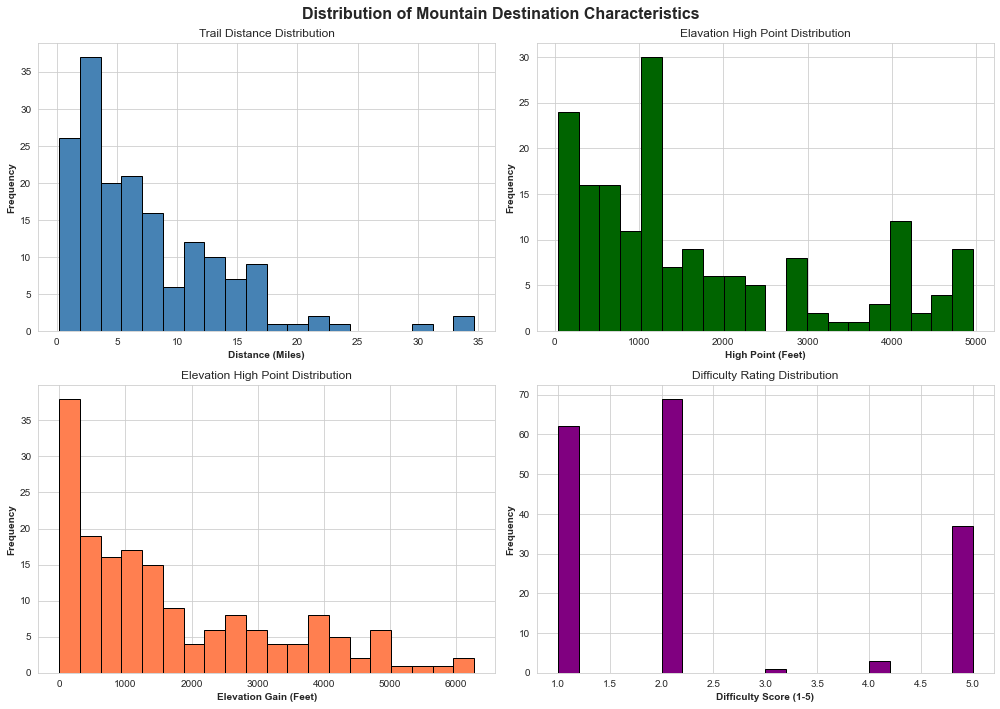

In [31]:
fig, axes = plt.subplots(2,2,figsize=(14,10))
fig.suptitle('Distribution of Mountain Destination Characteristics',fontsize=16,fontweight='bold')

axes[0,0].hist(df_clean['Distance_Miles'],bins=20,color='steelblue',edgecolor='black')
axes[0,0].set_xlabel('Distance (Miles)',fontweight='bold')
axes[0,0].set_ylabel('Frequency',fontweight='bold')
axes[0,0].set_title('Trail Distance Distribution')

axes[0,1].hist(df_clean['High_Point_Feet'],bins=20,color='darkgreen',edgecolor='black')
axes[0,1].set_xlabel('High Point (Feet)',fontweight='bold')
axes[0,1].set_ylabel('Frequency',fontweight='bold')
axes[0,1].set_title('Elavation High Point Distribution')

axes[1,0].hist(df_clean['Elevation_Gain_Feet'],bins=20,color='coral',edgecolor='black')
axes[1,0].set_xlabel('Elevation Gain (Feet)',fontweight='bold')
axes[1,0].set_ylabel('Frequency',fontweight='bold')
axes[1,0].set_title('Elevation High Point Distribution')

axes[1,1].hist(df_clean['Difficulty_Score'],bins=20,color='purple',edgecolor='black')
axes[1,1].set_xlabel('Difficulty Score (1-5)',fontweight='bold')
axes[1,1].set_ylabel('Frequency',fontweight='bold')
axes[1,1].set_title('Difficulty Rating Distribution')

plt.tight_layout()
plt.show()

### 4.2 Visualization 3: Correlation Analysis


In [32]:
correlation_matrix = df_clean[key_features].corr()
correlation_matrix

,Distance_Miles,High_Point_Feet,Elevation_Gain_Feet,Difficulty_Score
Distance_Miles,1.000000,0.449432,0.871244,0.751225
High_Point_Feet,0.449432,1.000000,0.604875,0.527766
Elevation_Gain_Feet,0.871244,0.604875,1.000000,0.870684
Difficulty_Score,0.751225,0.527766,0.870684,1.000000


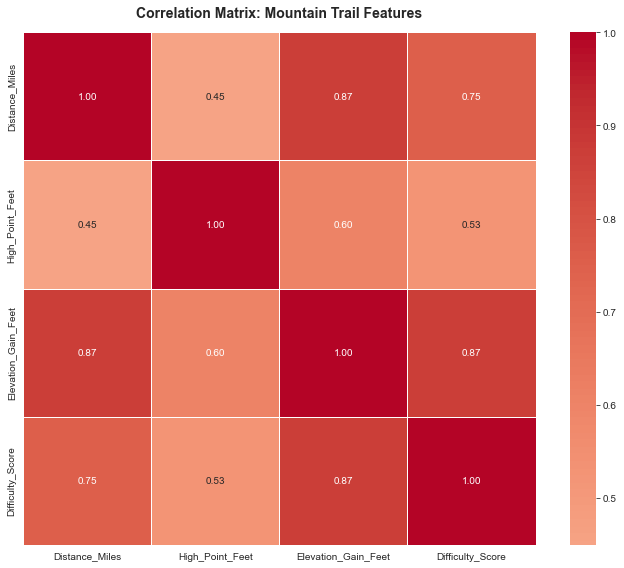

In [33]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm',center=0,square=True,linewidths=1,fmt='.2f')
plt.title('Correlation Matrix: Mountain Trail Features', fontsize =14, fontweight='bold',pad=15)
plt.tight_layout()
plt.show()

### 4.3 Visualization 3: Outlier Detection 

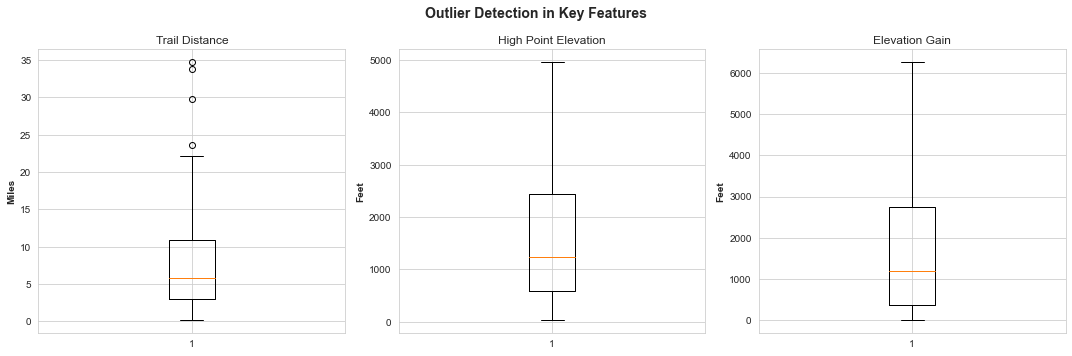

In [34]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
fig.suptitle('Outlier Detection in Key Features',fontsize=14,fontweight='bold')

axes[0].boxplot(df_clean['Distance_Miles'].dropna())
axes[0].set_ylabel('Miles',fontweight='bold')
axes[0].set_title('Trail Distance')

axes[1].boxplot(df_clean['High_Point_Feet'].dropna())
axes[1].set_ylabel('Feet',fontweight='bold')
axes[1].set_title('High Point Elevation')

axes[2].boxplot(df_clean['Elevation_Gain_Feet'].dropna())
axes[2].set_ylabel('Feet',fontweight='bold')
axes[2].set_title('Elevation Gain')

plt.tight_layout()
plt.show()

In [35]:
# Identift extreme outliers
print("Extreme Destinations (Potential 'Extreme Category'):")

extreme_distance = df_clean[df_clean['Distance_Miles']>df_clean['Distance_Miles'].quantile(0.95)]
extreme_elevation = df_clean[df_clean['High_Point_Feet']>df_clean['High_Point_Feet'].quantile(0.95)]
extreme_gain = df_clean[df_clean['Elevation_Gain_Feet']>df_clean['Elevation_Gain_Feet'].quantile(0.95)]

print(f" - Extremely long trails (>95th percentile): {len(extreme_distance)}")
print(f" - Extremely high peaks (>95th percentile): {len(extreme_elevation)}")
print(f" - Extremely elevation gain (>95th percentile): {len(extreme_gain)}")

Extreme Destinations (Potential 'Extreme Category'):
 - Extremely long trails (>95th percentile): 9
 - Extremely high peaks (>95th percentile): 9
 - Extremely elevation gain (>95th percentile): 9


## 5. Feature Selection and Selection 

In [36]:
# Select features for clustering
clustering_features = ['Distance_Miles','High_Point_Feet','Elevation_Gain_Feet','Difficulty_Score']
X = df_clean[clustering_features].copy()

print("Features selected for clustering: ")
for feature in clustering_features:
    print(f" {feature}")

Features selected for clustering: 
 Distance_Miles
 High_Point_Feet
 Elevation_Gain_Feet
 Difficulty_Score


In [38]:
# Standardize features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Data shape for cluseting : {X_scaled.shape}")

Data shape for cluseting : (172, 4)


# 6. Determine Optimal Number of Clusters

In [42]:
# Elbow method to find optimal k
inertias = []
silhouette_scores = []
k_range = range(2,8)

for k in k_range:
    kmeans=KMeans(n_clusters=k,random_state=42,n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

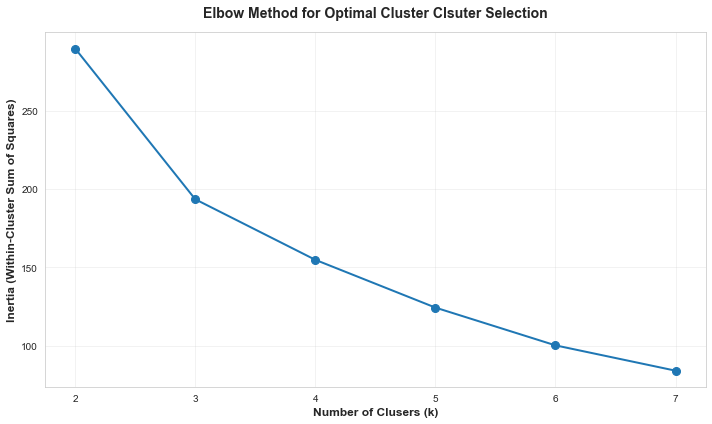

In [43]:
# Visualize elbow curve
plt.figure(figsize=(10,6))
plt.plot(k_range, inertias,marker='o',linewidth=2, markersize=8)
plt.xlabel('Number of Clusers (k)',fontsize=12,fontweight='bold')
plt.ylabel("Inertia (Within-Cluster Sum of Squares)",fontsize=12,fontweight='bold')
plt.title("Elbow Method for Optimal Cluster Clsuter Selection",fontsize=14,fontweight='bold',pad=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

As we can see from the chart using Elbow Method above, that, the optimal k we can use for KMeans model is three (3 clusters)

## 7. K-Means Clustering Analysis 

In [47]:
# Apply KMeans with optimal k=3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k,random_state=42,n_init=10)
df_clean['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"K-Means clustering complete with k={optimal_k}")
print("Clustering Distribution: ")
cluster_counts = df_clean['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count/len(df_clean)) * 100
    print(f" - Cluster {cluster}: {count} destinations ({percentage:.1f}%)")

K-Means clustering complete with k=3
Clustering Distribution: 
 - Cluster 0: 55 destinations (32.0%)
 - Cluster 1: 79 destinations (45.9%)
 - Cluster 2: 38 destinations (22.1%)


## 8. Cluster Characterization  

In [51]:
# Calculate mean values for each cluster
cluster_summary = df_clean.groupby('Cluster')[clustering_features].mean()

print("Cluster Profiles (Mean Values): ")
cluster_summary.round(2)

Cluster Profiles (Mean Values): 


,Distance_Miles,High_Point_Feet,Elevation_Gain_Feet,Difficulty_Score
Cluster,,,,
0,7.43,2459.18,1786.64,2.09
1,3.17,590.03,448.92,1.27
2,16.19,2966.84,4118.21,4.87


In [52]:
# Assign tier names based on characteristics
tier_names = {}
for cluster in range(optimal_k):
    avg_difficulty = cluster_summary.loc[cluster,'Difficulty_Score']
    avg_elevation = cluster_summary.loc[cluster,'High_Point_Feet']
    avg_gain = cluster_summary.loc[cluster, 'Elevation_Gain_Feet']
    
    # Tier classification logic
    if avg_difficulty >= 4 and avg_elevation > 8000:
        tier_names[cluster] = 'High-Altitude Technical'
    elif avg_difficulty >=3 and avg_gain > 2000:
        tier_names[cluster] = "Moderate Ridge Walks"
    elif avg_difficulty <= 2:
        tier_names[cluster] = "Accessible Foothills"
    else:
        tier_names[cluster] = "Intermediate Alpine"
        
df_clean['Experience_Tier'] = df_clean['Cluster'].map(tier_names)

In [58]:
print("Experience Tier Assignments: ")
for cluster, tier_name in tier_names.items():
    count = len(df_clean[df_clean['Cluster']==cluster])
    print(f"\nCluster {cluster}: {tier_name} ({count} destinations)")
    print(f" - Avg Distance: {cluster_summary.loc[cluster,'Distance_Miles']:.1f} miles")
    print(f" - Avg High Point: {cluster_summary.loc[cluster,'High_Point_Feet']:.0f} feet")
    print(f" - Avg Elevation Gain: {cluster_summary.loc[cluster, 'Elevation_Gain_Feet']:.0f} feet")
    print(f" - Avg Difficulty: {cluster_summary.loc[cluster,'Difficulty_Score']:.1f}/5")

Experience Tier Assignments: 

Cluster 0: Intermediate Alpine (55 destinations)
 - Avg Distance: 7.4 miles
 - Avg High Point: 2459 feet
 - Avg Elevation Gain: 1787 feet
 - Avg Difficulty: 2.1/5

Cluster 1: Accessible Foothills (79 destinations)
 - Avg Distance: 3.2 miles
 - Avg High Point: 590 feet
 - Avg Elevation Gain: 449 feet
 - Avg Difficulty: 1.3/5

Cluster 2: Moderate Ridge Walks (38 destinations)
 - Avg Distance: 16.2 miles
 - Avg High Point: 2967 feet
 - Avg Elevation Gain: 4118 feet
 - Avg Difficulty: 4.9/5


## 9. Cluster Visualizations 

### 9.1 Visualization 1: PCA 2D Scatter Plot

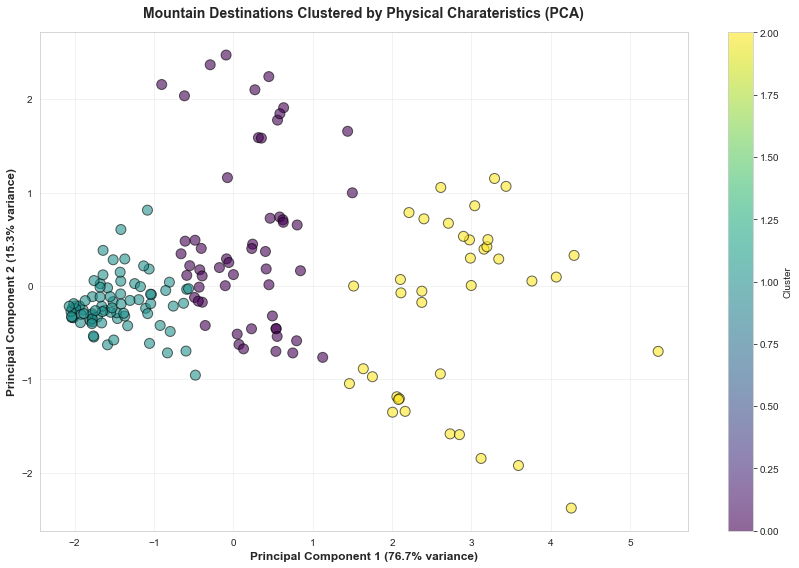

In [60]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12,8))
scatter = plt.scatter(X_pca[:,0],X_pca[:,1],c=df_clean['Cluster'], cmap='viridis',s=100,alpha=0.6,edgecolor='black')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12,fontweight='bold')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12,fontweight='bold')
plt.title('Mountain Destinations Clustered by Physical Charateristics (PCA)', fontsize=14, fontweight='bold',pad=15)
plt.colorbar(scatter,label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 9.2 Visualizations 2: Cluster Comparison by Features 

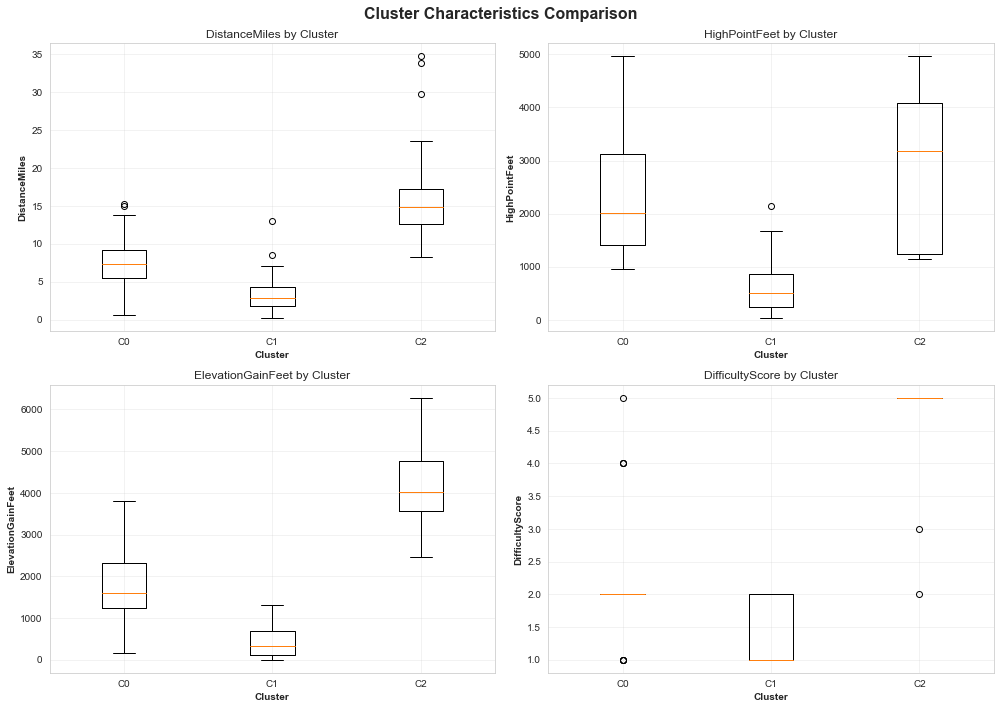

In [70]:
fig, axes = plt.subplots(2,2,figsize=(14,10))
fig.suptitle('Cluster Characteristics Comparison',fontsize=16,fontweight='bold')

for idx, feature in enumerate(clustering_features):
    row = idx // 2
    col = idx % 2
    
    cluster_data = [df_clean[df_clean['Cluster']==i][feature].values for i in range(optimal_k)]
    axes[row, col].boxplot(cluster_data, labels=[f'C{i}' for i in range(optimal_k)])
    axes[row,col].set_xlabel('Cluster',fontweight='bold')
    axes[row,col].set_ylabel(feature.replace('_',''),fontweight='bold')
    axes[row,col].set_title(f'{feature.replace("_","")} by Cluster')
    axes[row,col].grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 9.3 Visualization 3: 3D Scatter Plot 

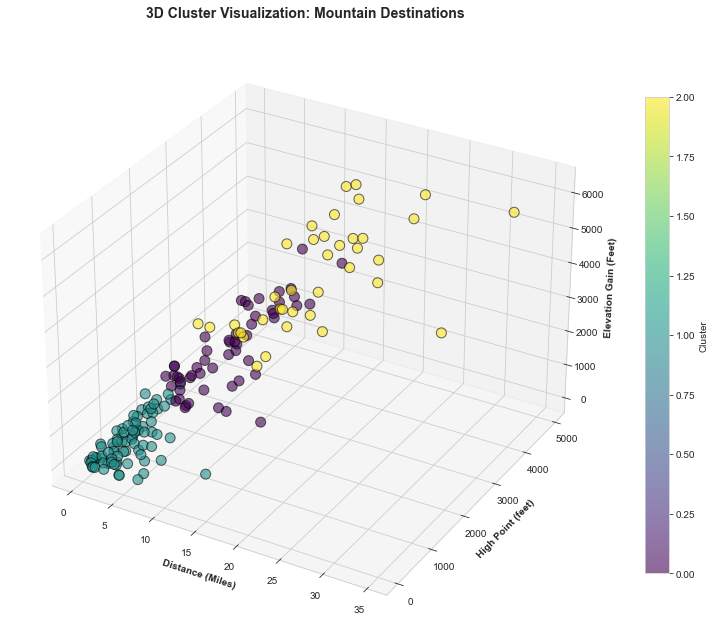

In [69]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111,projection='3d')

scatter = ax.scatter(df_clean['Distance_Miles'],
                     df_clean['High_Point_Feet'],
                     df_clean['Elevation_Gain_Feet'],
                     c=df_clean['Cluster'],
                     cmap='viridis',
                     s=100,
                     alpha=0.6,
                     edgecolors='black'
)

ax.set_xlabel('Distance (Miles)', fontweight='bold')
ax.set_ylabel('High Point (feet)',fontweight='bold')
ax.set_zlabel('Elevation Gain (Feet)',fontweight='bold')
ax.set_title("3D Cluster Visualization: Mountain Destinations",fontsize=14, fontweight='bold',pad=20)
plt.colorbar(scatter,label='Cluster',shrink=0.8)
plt.tight_layout()
plt.show()

## 10. Operational Recommendation

In [74]:
print("RESOURCE ALLOCATION GUIDE: ")

for cluster in range(optimal_k):
    tier_name = tier_names[cluster]
    cluster_data = df_clean[df_clean['Cluster']==cluster]
    count = len(cluster_data)
    
    print(f"\n{tier_name.upper()} (Cluster{cluster}):")
    print(f" - Number of Destinations: {count}")
    print(f" - Typical Distance: {cluster_summary.loc[cluster,'Distance_Miles']:.1f} miles")
    print(f" - Typical Elevation: {cluster_summary.loc[cluster,'High_Point_Feet']:.0f} ft")
    print(f" - Typical Gain: {cluster_summary.loc[cluster,'Elevation_Gain_Feet']:.0f} ft")
    
    # Staffing recommendations
    if cluster_summary.loc[cluster,'Difficulty_Score']>=4:
        print(" - Guide Requirments: Expert guides with technical climbing certification")
        print(" - Equipment: Full alpine gear, rope systems, advanced safety equipment")
        print(" - Group size: Maximum 4-6 participatants")
    elif cluster_summary.loc[cluster,'Difficulty_Score']>=3:
        print(" - Guide Requirements: Exprerienced guides with wildnerness first aid")
        print(" - Equipment: Standard hiking gear, navigation tools,emergency supplies")
        print(" - Group size: Maximum 8-10 participants")
    else:
        print("- Guide Requirements: Standard certified guides")
        print(" - Equipment: Basic hiking equipment, first aid kit")
        print(" - Group Size : Maximum 12-15 participants")

RESOURCE ALLOCATION GUIDE: 

INTERMEDIATE ALPINE (Cluster0):
 - Number of Destinations: 55
 - Typical Distance: 7.4 miles
 - Typical Elevation: 2459 ft
 - Typical Gain: 1787 ft
- Guide Requirements: Standard certified guides
 - Equipment: Basic hiking equipment, first aid kit
 - Group Size : Maximum 12-15 participants

ACCESSIBLE FOOTHILLS (Cluster1):
 - Number of Destinations: 79
 - Typical Distance: 3.2 miles
 - Typical Elevation: 590 ft
 - Typical Gain: 449 ft
- Guide Requirements: Standard certified guides
 - Equipment: Basic hiking equipment, first aid kit
 - Group Size : Maximum 12-15 participants

MODERATE RIDGE WALKS (Cluster2):
 - Number of Destinations: 38
 - Typical Distance: 16.2 miles
 - Typical Elevation: 2967 ft
 - Typical Gain: 4118 ft
 - Guide Requirments: Expert guides with technical climbing certification
 - Equipment: Full alpine gear, rope systems, advanced safety equipment
 - Group size: Maximum 4-6 participatants


## 12. Final Summary

This analysis categorizes 172 mountains destinations into 3 distinct experience tiers based physical characteristics: distance, elevation, elevation gain, and difficulty rating. The clustering provides data-driven framework for guide resource allocation, equipment planning, and safety protocol implementation.

**Experience Tier Classifications**:
--
1. **Tier 1: Accessible Foothills**
Cluster 1 - 79 Destinations (46% of portfolio)
- Ideal for introductory clients, family groups, and corporate team-building experience. High volume potential with lower operational complexity.

2. **Tier 2: Intermediate Alpine**
Cluster 0 - 55 Destinations (32% of Portfolio)
- Core offering for experienced hikers seeking challenge without technical skills. Balance accesibility with adventure appeal.

3. **Tier 3 : Moderate Ridge Walks**
Cluster 2 - 38 Destinations (22% of portfolio)
- Premium offering for experienced trekkers. High-margin, low-volume with significant preparation requirments. Strong differentiation opportunity.

**Strategic Recommendations**
-- 
**Immediate Action (0-3 months):**
1. Guide training program
2. Equipment Inventory
3. Pricing Strategy
**Medium Term Development (3-6 months):**
1. Create tier-specific marketing materials highlightinf difficulty progression
2. Develop "progression pathways" encouraging clients to advance through tiers
3. Establish partnerships for specialized Tier 3 equipment needs
**Long Term Strategy (6-12 months):**
1. Expand Tier 2 oferings (highest growth potential)
2. Consider sub-categorization within Tier 3 for ultra-premium experiences
3. Leverage data to identify gaps in destination portfolio
